<a href="https://colab.research.google.com/github/Arjun650/MachineLearning/blob/main/T5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers pandas torch


In [ ]:
!pip install catboost


In [ ]:
import numpy as np
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score , precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from transformers import RobertaTokenizer, RobertaModel
from transformers import T5Tokenizer, T5Model

from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/grouped_transcripts_with_timestamps (3).csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create a mapping for the labels
label_mapping = {
    'Statement': 1,
    'Question': 2,
    'Answer': 3
}

# Apply the mapping to create a new column 'Label_num'
df['Label_num'] = df['Label'].map(label_mapping)

# Verify the changes
df.head()


,Start Time Stamp,End Time Stamp,Label,Transcript,Label_num
0,00:00:04,00:00:15,Statement,Yeah. So can you tell me now? We'll go one aft...,1
1,00:00:19,00:00:19,Question,What is sampling? What is sampling?,2
2,00:00:26,00:00:26,Answer,Sampling means it is the process of converting...,3
3,00:00:33,00:00:39,Statement,OK. So suppose you sample a signal at. 10 kilo...,1
4,00:00:41,00:00:41,Question,What is the maximum frequency which will be av...,2


In [ ]:
X = df['Transcript'].values
Y = df['Label_num'].values

In [ ]:
print(df)

     Start Time Stamp End Time Stamp      Label  \
0            00:00:04       00:00:15  Statement   
1            00:00:19       00:00:19   Question   
2            00:00:26       00:00:26     Answer   
3            00:00:33       00:00:39  Statement   
4            00:00:41       00:00:41   Question   
...               ...            ...        ...   
2166         00:10:22       00:10:22   Question   
2167         00:10:24       00:10:24     Answer   
2168         00:10:28       00:10:29  Statement   
2169         00:10:32       00:10:32   Question   
2170         00:10:33       00:10:36  Statement   

                                             Transcript  Label_num  
0     Yeah. So can you tell me now? We'll go one aft...          1  
1                   What is sampling? What is sampling?          2  
2     Sampling means it is the process of converting...          3  
3     OK. So suppose you sample a signal at. 10 kilo...          1  
4     What is the maximum frequency which 

In [ ]:
from transformers import T5Tokenizer, T5EncoderModel

df = pd.DataFrame(df)  # Assuming df is already defined with the relevant data

# Initialize T5 tokenizer and encoder model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5EncoderModel.from_pretrained('t5-small')

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Function to get embeddings
def get_embeddings(text):
    # Tokenize the input text
    input_ids = tokenizer.encode(text, return_tensors='pt', truncation=True, padding=True).to(device)
    with torch.no_grad():
        # Get the outputs from the encoder model
        outputs = model(input_ids=input_ids)
        # Get the last hidden states
        last_hidden_states = outputs.last_hidden_state
        # Use the first token's hidden state as the embedding
        return last_hidden_states[:, 0, :].cpu().numpy()  # Convert tensor to numpy array

# Apply the embedding function to the Transcript column
df['Embeddings'] = df['Transcript'].apply(get_embeddings)

# Display the DataFrame with embeddings
print(df[['Transcript', 'Embeddings']])

                                             Transcript  \
0     Yeah. So can you tell me now? We'll go one aft...   
1                   What is sampling? What is sampling?   
2     Sampling means it is the process of converting...   
3     OK. So suppose you sample a signal at. 10 kilo...   
4     What is the maximum frequency which will be av...   
...                                                 ...   
2166                     You can't use black and white.   
2167                                          Yes, Sir.   
2168    OK. Thank you very much. So basically, yes Sir.   
2169                          You are saying something?   
2170  No, Sir. No, Sir. Thank you. Have a good eveni...   

                                             Embeddings  
0     [[0.0700756, 0.118519604, -0.38123026, -0.2393...  
1     [[-0.040794227, 0.0038366644, 0.22383925, -0.0...  
2     [[-0.041476984, -0.007535542, 0.095644034, -0....  
3     [[-0.16923302, -0.0073944805, -0.34185377, -0....  
4

In [ ]:
print(df['Embeddings'])

0       [[0.0700756, 0.118519604, -0.38123026, -0.2393...
1       [[-0.040794227, 0.0038366644, 0.22383925, -0.0...
2       [[-0.041476984, -0.007535542, 0.095644034, -0....
3       [[-0.16923302, -0.0073944805, -0.34185377, -0....
4       [[0.008272053, 0.1024098, 0.3674944, -0.258583...
                              ...                        
2166    [[0.34217972, -0.13486083, -0.21647163, -0.136...
2167    [[0.05511026, -0.13677469, -0.08923222, -0.166...
2168    [[-0.115585655, -0.014043532, -0.29434192, -0....
2169    [[0.018955199, -0.24792895, -0.4473636, -0.186...
2170    [[-0.012840881, 0.007969226, 0.14997955, 0.012...
Name: Embeddings, Length: 2171, dtype: object


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['Embeddings'], Y, test_size = 0.2, stratify = Y, random_state = 2)

In [ ]:
X_train = np.vstack(X_train.tolist())
Y_train = np.vstack(Y_train.tolist())
X_test = np.vstack(X_test.tolist())
Y_test = np.array(Y_test.tolist())

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Training Accuracy: 81.51%
Test Accuracy: 67.36%


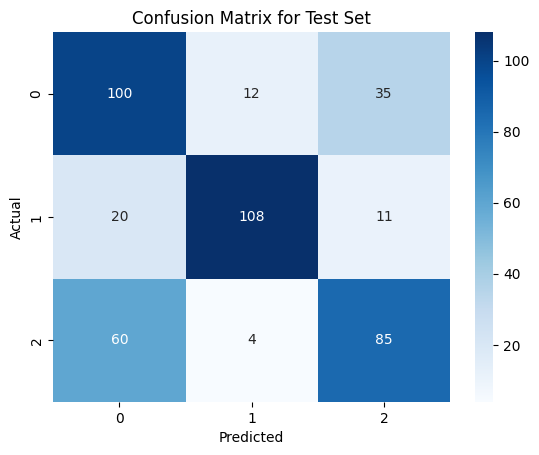

Precision: 68.83%
Recall: 67.36%
F1 Score: 67.71%


In [ ]:
def knn_classifier(X_train, Y_train, X_test, Y_test, n_neighbors=5, weights='uniform', p=2):

    # Create the KNN model with given parameters
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)

    # Fit the model on the training data
    knn_model.fit(X_train, Y_train)

    # Predicting on the training set
    Y_train_pred = knn_model.predict(X_train)

    # Predicting on the test set
    Y_test_pred = knn_model.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

    # Precision, recall, and F1 score
    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

# Example of usage:
knn_classifier(X_train, Y_train, X_test, Y_test, n_neighbors=3, weights='uniform', p=2)


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Best Hyperparameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 21}
Training Accuracy with Best Model: 98.79%
Test Accuracy with Best Model: 68.05%


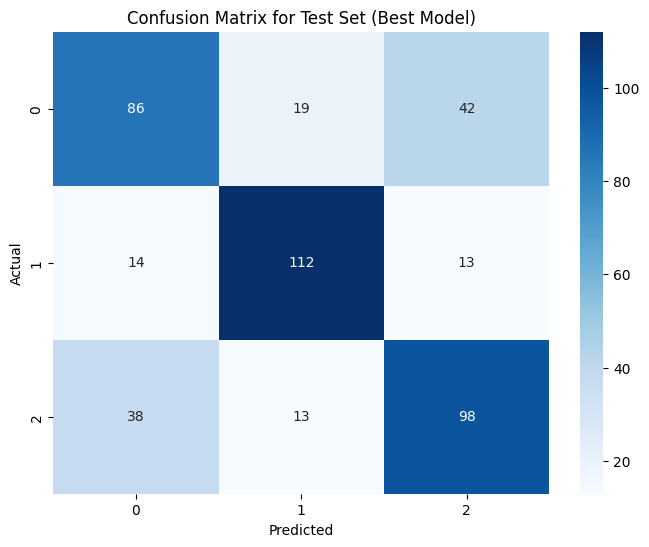

Precision: 67.85%
Recall: 68.05%
F1 Score: 67.92%


In [ ]:
def knn_with_random_search(X_train, Y_train, X_test, Y_test):
    # Standardize the features (important for KNN)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define hyperparameter distribution for RandomizedSearchCV
    param_dist = {
        'n_neighbors': range(1, 30),            # n_neighbors between 1 and 30
        'weights': ['uniform', 'distance'],     # Uniform or distance-based weighting
        'p': [1, 2]                             # Manhattan distance (p=1) or Euclidean distance (p=2)
    }

    # Create the KNN model
    knn_model = KNeighborsClassifier()

    # Set up RandomizedSearchCV with 5-fold cross-validation
    random_search = RandomizedSearchCV(estimator=knn_model, param_distributions=param_dist,
                                       n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

    # Fit RandomizedSearchCV on the training data
    random_search.fit(X_train_scaled, Y_train)

    # Get the best parameters
    best_params = random_search.best_params_
    print(f"Best Hyperparameters: {best_params}")

    # Get the best model from RandomizedSearchCV
    best_knn_model = random_search.best_estimator_

    # Predicting on the training set
    Y_train_pred = best_knn_model.predict(X_train_scaled)

    # Predicting on the test set
    Y_test_pred = best_knn_model.predict(X_test_scaled)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy with Best Model: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy with Best Model: {test_accuracy * 100:.2f}%')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set (Best Model)')
    plt.show()

    # Calculate other performance metrics
    precision = precision_score(Y_test, Y_test_pred, average='weighted', zero_division=0)
    recall = recall_score(Y_test, Y_test_pred, average='weighted', zero_division=0)
    f1 = f1_score(Y_test, Y_test_pred, average='weighted', zero_division=0)

    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

# Example of usage:
knn_with_random_search(X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 89.69%
Test Accuracy: 76.09%


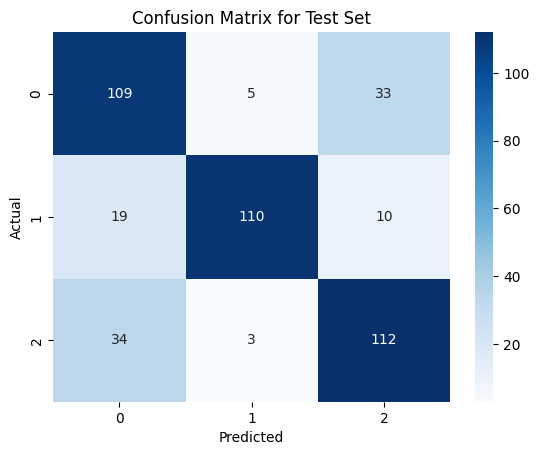

Precision: 77.28
Recall: 76.09
F1 Score: 76.43


In [ ]:
def train_logistic_regression(X_train, Y_train):
    # Train a logistic regression model.
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    return model

def predict(model, X):
    # Make predictions using the trained logistic regression model.
    return model.predict(X)

def evaluate_accuracy(Y_true, Y_pred):
    # Evaluate and return the accuracy of the model.
    accuracy = accuracy_score(Y_true, Y_pred)
    return accuracy

def plot_confusion_matrix(Y_true, Y_pred):
    # Plot the confusion matrix as a heatmap.
    conf_matrix = confusion_matrix(Y_true, Y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Train the model
log_reg_model = train_logistic_regression(X_train, Y_train)

# Make predictions
Y_train_pred = predict(log_reg_model, X_train)
Y_test_pred = predict(log_reg_model, X_test)

# Evaluate and print training accuracy
train_accuracy = evaluate_accuracy(Y_train, Y_train_pred)
print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

# Evaluate and print test accuracy
test_accuracy = evaluate_accuracy(Y_test, Y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Plot confusion matrix for test set
plot_confusion_matrix(Y_test, Y_test_pred)

precision = precision_score(Y_test, Y_test_pred, average='weighted')
recall = recall_score(Y_test, Y_test_pred, average='weighted')
f1 = f1_score(Y_test, Y_test_pred, average='weighted')

print(f'Precision: {precision * 100:.2f}')
print(f'Recall: {recall * 100:.2f}')
print(f'F1 Score: {f1 * 100:.2f}')

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/

Training Accuracy with Best Model: 92.11%
Test Accuracy with Best Model: 74.48%
Precision: 75.40
Recall: 74.48
F1 Score: 74.76


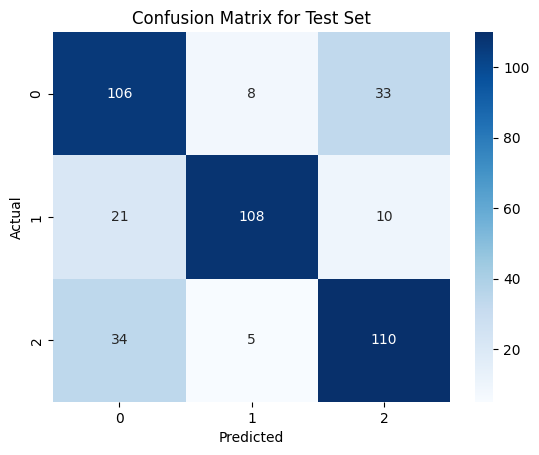

In [ ]:
def logistic_regression_with_random_search(X_train, Y_train):
    # Define hyperparameter distribution for RandomizedSearchCV
    param_dist = {
        'penalty': ['l1', 'l2', 'elasticnet'],         # Removed 'none'
        'C': [0.1, 1, 10, 100, 1000],                  # Regularization strength
        'solver': ['liblinear', 'saga'],                # Solvers: liblinear (supports l1/l2), saga (supports elasticnet)
        'max_iter': [100, 200, 300],                    # Maximum iterations for convergence
        'l1_ratio': [0.0, 0.5, 1.0]                    # Only used for 'elasticnet' penalty
    }

    # Create the Logistic Regression model
    log_reg_model = LogisticRegression()

    # Set up RandomizedSearchCV with 5-fold cross-validation
    random_search = RandomizedSearchCV(estimator=log_reg_model, param_distributions=param_dist,
                                       n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

    # Fit RandomizedSearchCV on the training data
    random_search.fit(X_train, Y_train)

    # Filter out incompatible parameters (e.g., using l1_ratio with non-elasticnet penalty)
    def filter_invalid_params(params):
        if params['penalty'] != 'elasticnet':
            params['l1_ratio'] = None
        if params['penalty'] == 'elasticnet' and params['solver'] == 'liblinear':
            return False
        return True

    # Filter best_params to avoid mismatches
    best_params = random_search.best_params_
    if not filter_invalid_params(best_params):
        print("Invalid hyperparameter combination found, retrying search.")
        random_search = RandomizedSearchCV(estimator=log_reg_model, param_distributions=param_dist,
                                           n_iter=10, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
        random_search.fit(X_train, Y_train)

    # Get the best model from RandomizedSearchCV
    best_log_reg_model = random_search.best_estimator_

    return best_log_reg_model

# Function to make predictions
def predict(model, X):
    return model.predict(X)

# Function to evaluate accuracy
def evaluate_accuracy(Y_true, Y_pred):
    return accuracy_score(Y_true, Y_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(Y_true, Y_pred):
    conf_matrix = confusion_matrix(Y_true, Y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage
def logistic_regression_pipeline(X_train, Y_train, X_test, Y_test):
    # Train the model with hyperparameter tuning
    best_log_reg_model = logistic_regression_with_random_search(X_train, Y_train)

    # Make predictions on training and test data
    Y_train_pred = predict(best_log_reg_model, X_train)
    Y_test_pred = predict(best_log_reg_model, X_test)

    # Evaluate and print training accuracy
    train_accuracy = evaluate_accuracy(Y_train, Y_train_pred)
    print(f'Training Accuracy with Best Model: {train_accuracy * 100:.2f}%')

    # Evaluate and print test accuracy
    test_accuracy = evaluate_accuracy(Y_test, Y_test_pred)
    print(f'Test Accuracy with Best Model: {test_accuracy * 100:.2f}%')

    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print(f'Precision: {precision * 100:.2f}')
    print(f'Recall: {recall * 100:.2f}')
    print(f'F1 Score: {f1 * 100:.2f}')

    # Plot confusion matrix for the test set
    plot_confusion_matrix(Y_test, Y_test_pred)

# Call this with your dataset like so:
logistic_regression_pipeline(X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
Training Accuracy: 88.82%
Test Accuracy: 74.48%
Precision: 75.72
Recall: 74.48
F1 Score: 74.84


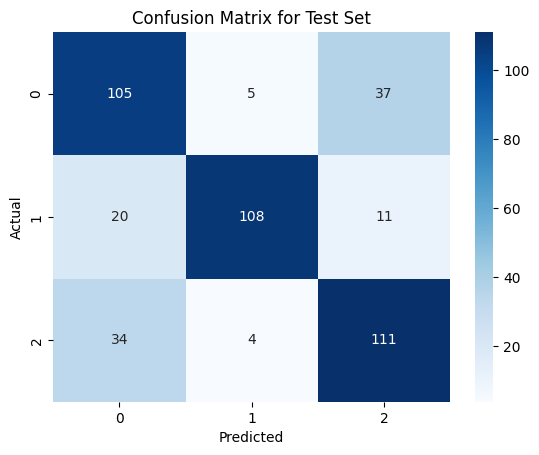

In [ ]:
def svm_classifier(X_train, Y_train, X_test, Y_test):
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'C': [0.1, 1, 10, 100],  # Regularization parameter
        'gamma': ['scale', 'auto', 0.1, 1],  # Kernel coefficient
        'kernel': ['linear', 'rbf', 'poly']  # Kernel type
    }

    # Initialize the SVM model
    svm_model = SVC()

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid,
                               scoring='accuracy', cv=5, n_jobs=-1)

    # Train the model with the best hyperparameters
    grid_search.fit(X_train, Y_train)

    # Best parameters from the grid search
    print(f"Best Parameters: {grid_search.best_params_}")

    # Predicting on the training set with the best model
    Y_train_pred = grid_search.predict(X_train)

    # Predicting on the test set with the best model
    Y_test_pred = grid_search.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print(f'Precision: {precision * 100:.2f}')
    print(f'Recall: {recall * 100:.2f}')
    print(f'F1 Score: {f1 * 100:.2f}')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
svm_classifier(X_train, Y_train, X_test, Y_test)

Training Accuracy: 98.79%
Test Accuracy: 59.08%
Precision: 59.26
Recall: 59.08
F1 Score: 59.16


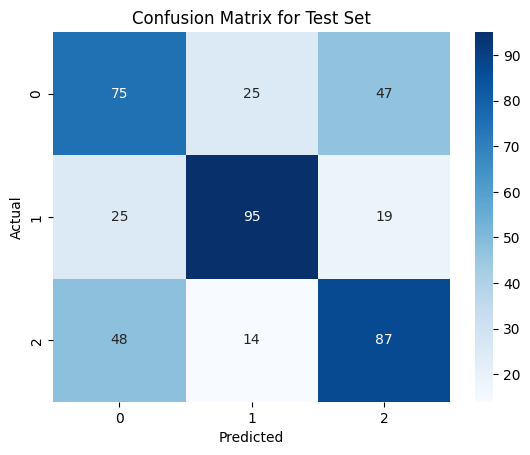

In [ ]:
def decision_tree_classifier(X_train, Y_train, X_test, Y_test):


    # Initialize the Decision Tree model
    dt_model = DecisionTreeClassifier()  # You can adjust parameters like max_depth, criterion, etc.

    # Train the model on the training data
    dt_model.fit(X_train, Y_train)

    # Predicting on the training set
    Y_train_pred = dt_model.predict(X_train)

    # Predicting on the test set
    Y_test_pred = dt_model.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print(f'Precision: {precision * 100:.2f}')
    print(f'Recall: {recall * 100:.2f}')
    print(f'F1 Score: {f1 * 100:.2f}')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
decision_tree_classifier(X_train, Y_train, X_test, Y_test)

Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}
Training Accuracy: 80.36%
Test Accuracy: 62.76%
Precision: 63.34
Recall: 62.76
F1 Score: 62.98


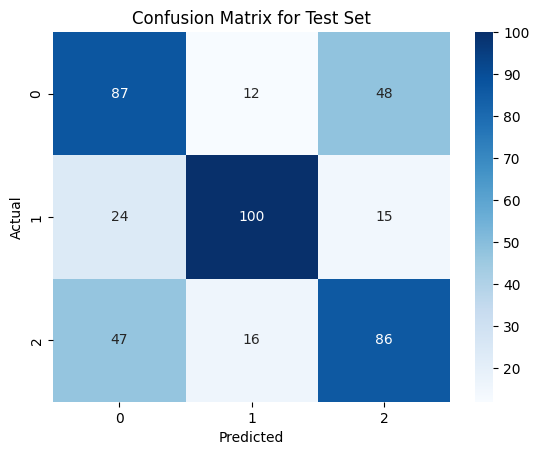

In [ ]:
def decision_tree_classifier(X_train, Y_train, X_test, Y_test):
    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
        'max_depth': [None, 5, 10, 15, 20],  # Maximum depth of the tree
        'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 5, 10]   # Minimum number of samples required to be at a leaf node
    }

    # Initialize the Decision Tree model
    dt_model = DecisionTreeClassifier()

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid,
                               scoring='accuracy', cv=5, n_jobs=-1)

    # Train the model with the best hyperparameters
    grid_search.fit(X_train, Y_train)

    # Best parameters from the grid search
    print(f"Best Parameters: {grid_search.best_params_}")

    # Predicting on the training set with the best model
    Y_train_pred = grid_search.predict(X_train)

    # Predicting on the test set with the best model
    Y_test_pred = grid_search.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print(f'Precision: {precision * 100:.2f}')
    print(f'Recall: {recall * 100:.2f}')
    print(f'F1 Score: {f1 * 100:.2f}')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
decision_tree_classifier(X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Training Accuracy: 98.79%
Test Accuracy: 71.49%
Precision: 73.15
Recall: 71.49
F1 Score: 71.84


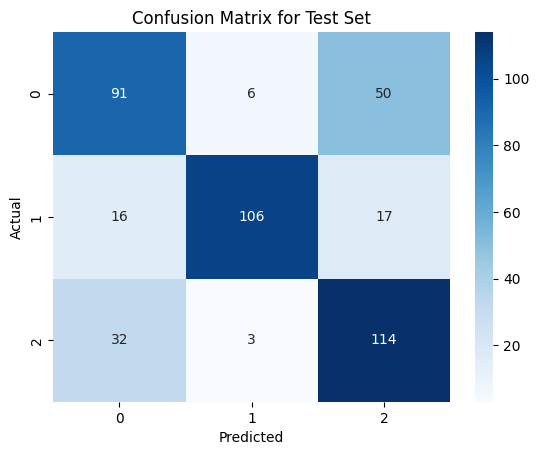

In [ ]:
def random_forest_classifier(X_train, Y_train, X_test, Y_test):

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier()  # You can adjust parameters like n_estimators, max_depth, etc.

    # Train the model on the training data
    rf_model.fit(X_train, Y_train)

    # Predicting on the training set
    Y_train_pred = rf_model.predict(X_train)

    # Predicting on the test set
    Y_test_pred = rf_model.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print(f'Precision: {precision * 100:.2f}')
    print(f'Recall: {recall * 100:.2f}')
    print(f'F1 Score: {f1 * 100:.2f}')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
random_forest_classifier(X_train, Y_train, X_test, Y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}
Training Accuracy: 98.68%
Test Accuracy: 71.49%
Precision: 72.56
Recall: 71.49
F1 Score: 71.71


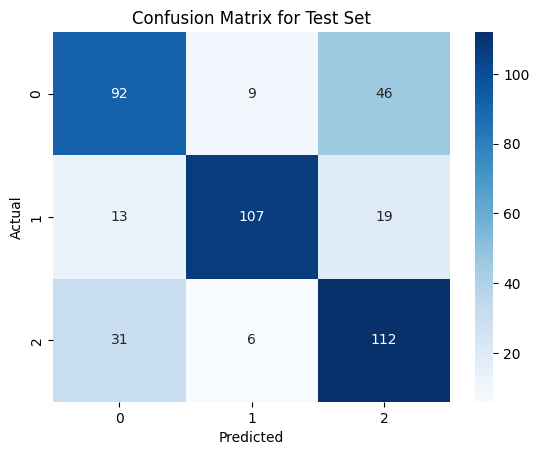

In [ ]:


def random_forest_classifier(X_train, Y_train, X_test, Y_test):
    # Define the parameter grid for hyperparameter tuning (reduced grid)
    param_grid = {
        'n_estimators': [50],  # Number of trees in the forest (reduced)
        'max_depth': [None, 10],  # Maximum depth of the tree (reduced)
        'min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node
        'max_features': ['sqrt', 'log2']  # Number of features to consider when looking for the best split
    }

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier()

    # Use RandomizedSearchCV for hyperparameter tuning (10 random parameter combinations)
    random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid,
                                       n_iter=10, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

    # Train the model with the best hyperparameters
    random_search.fit(X_train, Y_train)

    # Best parameters from the search
    print(f"Best Parameters: {random_search.best_params_}")

    # Predicting on the training set with the best model
    Y_train_pred = random_search.predict(X_train)

    # Predicting on the test set with the best model
    Y_test_pred = random_search.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Additional metrics
    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print(f'Precision: {precision * 100:.2f}')
    print(f'Recall: {recall * 100:.2f}')
    print(f'F1 Score: {f1 * 100:.2f}')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
random_forest_classifier(X_train, Y_train, X_test, Y_test)


Training Accuracy: 98.79%
Test Accuracy: 74.48%
Precision: 75.37
Recall: 74.48
F1 Score: 74.72


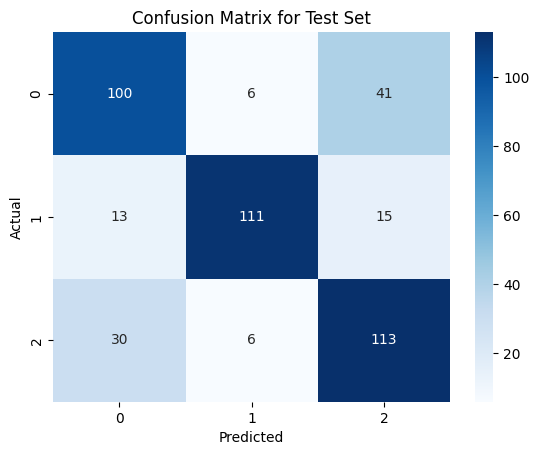

In [ ]:
def catboost_classifier(X_train, Y_train, X_test, Y_test):


    # Initialize the CatBoost model
    catboost_model = CatBoostClassifier(silent=True)

    # Train the model on the training data
    catboost_model.fit(X_train, Y_train)

    # Predicting on the training set
    Y_train_pred = catboost_model.predict(X_train)

    # Predicting on the test set
    Y_test_pred = catboost_model.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print(f'Precision: {precision * 100:.2f}')
    print(f'Recall: {recall * 100:.2f}')
    print(f'F1 Score: {f1 * 100:.2f}')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
catboost_classifier(X_train, Y_train, X_test, Y_test)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 4, 'border_count': 32}
Training Accuracy: 90.90%
Test Accuracy: 73.56%
Precision: 74.28%
Recall: 73.56%
F1 Score: 73.67%


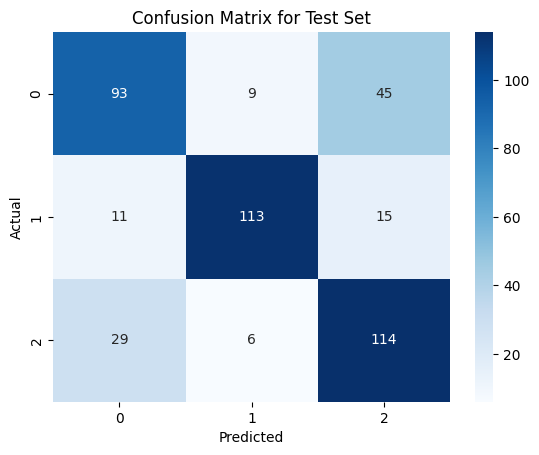

In [ ]:
def catboost_classifier(X_train, Y_train, X_test, Y_test):
    # Simplified parameter grid for faster search
    param_grid = {
        'iterations': [100, 200],  # Fewer boosting rounds
        'learning_rate': [0.01, 0.1, 0.2],  # Conservative learning rates
        'depth': [4, 6],  # Shallow trees for faster training
        'l2_leaf_reg': [1, 3],  # Fewer regularization levels
        'border_count': [32],  # Fixed border count for simplicity
    }

    # Initialize the CatBoost model with early stopping
    catboost_model = CatBoostClassifier(silent=True, early_stopping_rounds=20)

    # Use RandomizedSearchCV with reduced trials
    grid_search = RandomizedSearchCV(
        estimator=catboost_model,
        param_distributions=param_grid,
        scoring='accuracy',
        cv=2,  # Fewer folds to speed up
        n_jobs=-1,
        verbose=1,
        n_iter=5  # Reduced number of iterations
    )

    # Train the model with the best hyperparameters
    grid_search.fit(X_train, Y_train)

    # Best parameters from the grid search
    print(f"Best Parameters: {grid_search.best_params_}")

    # Predicting on the training and test sets
    Y_train_pred = grid_search.predict(X_train)
    Y_test_pred = grid_search.predict(X_test)

    # Calculating and printing accuracies
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Calculating additional metrics
    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # Plotting confusion matrix
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
catboost_classifier(X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Training Accuracy: 73.50%
Test Accuracy: 67.36%
Precision: 68.84%
Recall: 67.36%
F1 Score: 67.83%


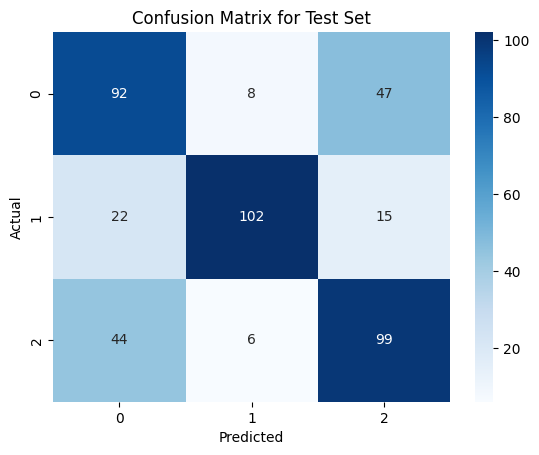

In [ ]:
def adaboost_classifier(X_train, Y_train, X_test, Y_test):


    # Initialize the base model (Decision Tree)
    base_model = DecisionTreeClassifier(max_depth=1)  # Using a Decision Stump as the base learner

    # Initialize the AdaBoost model
    ada_model = AdaBoostClassifier(estimator=base_model, n_estimators=50)  # Use 'estimator' instead of 'base_estimator'

    # Train the model on the training data
    ada_model.fit(X_train, Y_train)

    # Predicting on the training set
    Y_train_pred = ada_model.predict(X_train)

    # Predicting on the test set
    Y_test_pred = ada_model.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
adaboost_classifier(X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Parameters: {'estimator__max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 100}
Training Accuracy: 82.49%
Test Accuracy: 70.57%
Precision: 72.58%
Recall: 70.57%
F1 Score: 70.97%


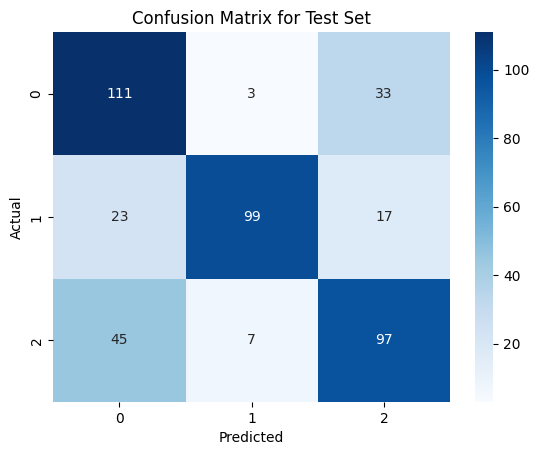

In [ ]:
def adaboost_classifier(X_train, Y_train, X_test, Y_test):
    # Initialize the base model (Decision Tree)
    base_model = DecisionTreeClassifier(max_depth=1)  # Using a Decision Stump as the base learner

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100],  # Number of weak learners
        'learning_rate': [0.01, 0.1],  # Weight applied to each classifier
        'estimator__max_depth': [1, 2, 3]  # Depth of the base learner (Decision Tree)
    }

    # Initialize the AdaBoost model with the base estimator
    ada_model = AdaBoostClassifier(estimator=base_model)

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=ada_model, param_grid=param_grid,
                               scoring='accuracy', cv=5, n_jobs=-1)

    # Train the model with the best hyperparameters
    grid_search.fit(X_train, Y_train)

    # Best parameters from the grid search
    print(f"Best Parameters: {grid_search.best_params_}")

    # Predicting on the training set with the best model
    Y_train_pred = grid_search.predict(X_train)

    # Predicting on the test set with the best model
    Y_test_pred = grid_search.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')

    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')


    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
adaboost_classifier(X_train, Y_train, X_test, Y_test)

Training Accuracy: 98.79%
Test Accuracy: 74.02%


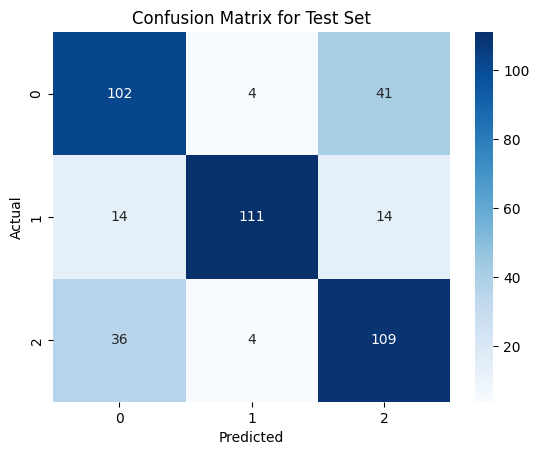

In [ ]:
def xgboost_classifier(X_train, Y_train, X_test, Y_test):


    # Initialize the XGBoost model
    xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')  # You can adjust parameters like n_estimators, max_depth, etc.

    # Train the model on the training data
    xgb_model.fit(X_train, Y_train)

    # Predicting on the training set
    Y_train_pred = xgb_model.predict(X_train)

    # Predicting on the test set
    Y_test_pred = xgb_model.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
# Adjust the labels to start from 0
Y_train_adjusted = Y_train - 1
Y_test_adjusted = Y_test - 1

# Call the classifier with adjusted labels
xgboost_classifier(X_train, Y_train_adjusted, X_test, Y_test_adjusted)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [11:12:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Training Accuracy: 98.79%
Test Accuracy: 72.87%
Precision: 74.39%
Recall: 72.87%
F1 Score: 73.24%


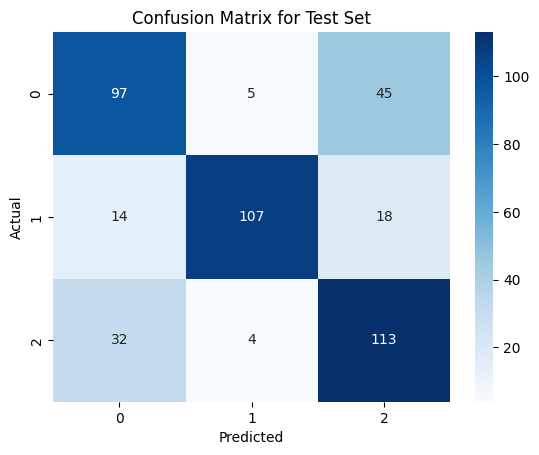

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def xgboost_classifier(X_train, Y_train, X_test, Y_test):
    # Parameter grid for XGBoost
    param_grid = {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }

    # Initialize the XGBoost model
    xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

    # RandomizedSearchCV for hyperparameter tuning
    grid_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                     scoring='accuracy', cv=3, n_iter=10, n_jobs=-1, verbose=1)

    # Train the model
    grid_search.fit(X_train, Y_train)

    # Display the best parameters
    print(f"Best Parameters: {grid_search.best_params_}")

    # Predict on train and test data
    Y_train_pred = grid_search.predict(X_train)
    Y_test_pred = grid_search.predict(X_test)

    # Accuracy
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Precision, Recall, F1 Score
    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # Confusion Matrix
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
# Adjust the labels to start from 0 if needed
Y_train_adjusted = Y_train - 1
Y_test_adjusted = Y_test - 1

# Call the classifier with adjusted labels
xgboost_classifier(X_train, Y_train_adjusted, X_test, Y_test_adjusted)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 69.64%
Test Accuracy: 67.36%
Precision: 68.41%
Recall: 67.36%
F1 Score: 67.34%


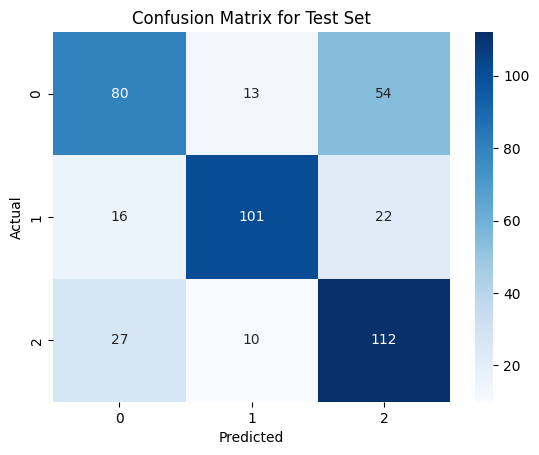

In [ ]:
def naive_bayes_classifier(X_train, Y_train, X_test, Y_test):


    # Convert sparse matrices to dense if needed
    if hasattr(X_train, 'toarray'):
        X_train = X_train.toarray()
    if hasattr(X_test, 'toarray'):
        X_test = X_test.toarray()

    # Initialize the Naive Bayes model
    nb_model = GaussianNB()  # You can use different variants like MultinomialNB or BernoulliNB as needed

    # Train the model on the training data
    nb_model.fit(X_train, Y_train)

    # Predicting on the training set
    Y_train_pred = nb_model.predict(X_train)

    # Predicting on the test set
    Y_test_pred = nb_model.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    precision = precision_score(Y_test, Y_test_pred, average='weighted')
    recall = recall_score(Y_test, Y_test_pred, average='weighted')
    f1 = f1_score(Y_test, Y_test_pred, average='weighted')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
naive_bayes_classifier(X_train, Y_train, X_test, Y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'var_smoothing': 1e-09}
Training Accuracy: 69.64%
Test Accuracy: 67.36%


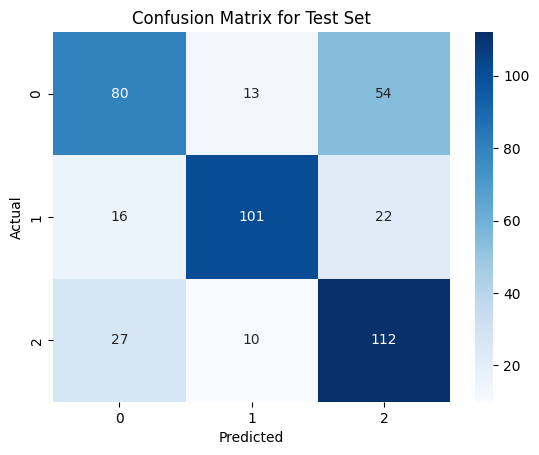

In [ ]:
def naive_bayes_classifier(X_train, Y_train, X_test, Y_test):
    # Convert sparse matrices to dense if needed
    if hasattr(X_train, 'toarray'):
        X_train = X_train.toarray()
    if hasattr(X_test, 'toarray'):
        X_test = X_test.toarray()

    # Initialize the Naive Bayes model
    nb_model = GaussianNB()

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]  # Smoothing parameter
    }

    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid,
                               scoring='accuracy', cv=5, n_jobs=-1)

    # Train the model with the best hyperparameters
    grid_search.fit(X_train, Y_train)

    # Best parameters from the grid search
    print(f"Best Parameters: {grid_search.best_params_}")

    # Predicting on the training set with the best model
    Y_train_pred = grid_search.predict(X_train)

    # Predicting on the test set with the best model
    Y_test_pred = grid_search.predict(X_test)

    # Calculating accuracy for the training set
    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    # Calculating accuracy for the test set
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

    # Confusion matrix for the test set
    test_conf_matrix = confusion_matrix(Y_test, Y_test_pred)
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix for Test Set')
    plt.show()

# Example usage (assuming you have X_train, Y_train, X_test, Y_test):
naive_bayes_classifier(X_train, Y_train, X_test, Y_test)